# Gradient Ascent 

- Andrei Dugăeșescu 

<br>

The difference between **Gradient Ascent** and **Gradient Descent** is in the sign. **Gradient Ascent** means changing the parameters according to the direction of the gradient of the function (therefore increasing its value). Henceforth **Gradient Descent** implies moving against the gradient (and thus decreasing the value of the function).

When training a network (optimizing a loss function), we do not want to increase the **loss**, quite the opposite. This is why we would use **Gradient Descent**. However, if instead we would like to maximize the activations of a network, then **Gradient Ascent** is the way to do it.


$$
    \text{Gradient Ascent on} \; (f) = \text{Gradient Descent on} \; (-f)
$$

<br>

<div align="center">
  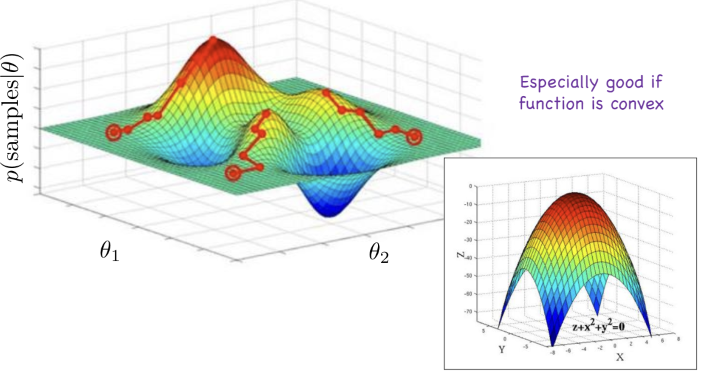
</div>

# Filter Visualization

To try and understand what a network "is looking for" in an image, one idea would be to inspect the kinds of input that illicit a strong response. One rather simple way would be to pass in images from the training set and check in each instance what images (or parts of images) have higher activations. A more target approach however, showed in this notebook, is to construct inputs for precisely this purpose (by using Gradient Ascent). The process goes as follows:


1. Initialize Parameters
2. Run the forward pass
3. Compute Gradient

3. Update Parameters

$$
  \large \theta_{new} = \theta_{old} + \alpha \nabla_{\theta} J(\theta)
$$

4. Repeat for a given number of epochs

In [1]:
from tqdm.auto import tqdm
from torch import Tensor

import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torchvision
import random
import torch
import os

## Set seed for reproducibility 

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## Loading the model - pretrained VGG16 

In [4]:
model = torchvision.models.vgg16(weights='DEFAULT')

model = model.to(device)
model = model.eval()

## Helpers (normalization and image scaling) 

In [5]:
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

mean = torch.tensor(mean).view(1, -1, 1, 1).to(device)
std  = torch.tensor(std ).view(1, -1, 1, 1).to(device)

In [6]:
def norm(x: Tensor) -> Tensor:
    """Normalize a Tensor with Imagenet statistics"""
    return (x - mean) / std

In [7]:
def deprocess_image(image: Tensor) -> np.ndarray:
    image = image.clone().detach()[0]
    image -= image.mean()
    image /= (image.std() + 1e-5)
    image *= 0.1
    
    image = image.permute(1, 2, 0).cpu().numpy()
    image += 0.5
    image = np.clip(image, 0, 1)
    
    image *= 255
    image = np.clip(image, 0, 255).astype('uint8')
    return image

In [8]:
def normalize(x: Tensor) -> Tensor:
    """Normalize a Tensor by its L2 norm"""
    return x / (torch.sqrt(torch.mean(torch.square(x))) + 1e-5)

# Selecting the layers to visualize 

In [9]:
layer_names = ['features.2', 'features.7', 'features.14', 'features.17', 'features.24']
alpha, n = 1., 4

# Saving activations with Hooks

A PyTorch hook is a function that allows you to register a callback on a specific tensor to perform custom actions during forward or backward passes of a neural network. For constructing the visualization, we will hook the target layer in order to save its activations.

In [10]:
activations = {}

def save_activations(name):
    
    def hook(module, input, output):
        activations[name] = output
    
    return hook

# Constructing the visualizations

In [11]:
%%time

kept_filters = dict()

for layer_name in tqdm(layer_names, leave=False):
    
    filters = []
    
    # Find the layer we want to hook (knowing  its name)
    hook = None
    for name, module in model.named_modules():
        if name == layer_name:
            hook = module.register_forward_hook(save_activations(name))
            break
        
    for filter_index in range(64):
        
        x = torch.rand(1, 3, 128, 128)
        x = x.to(device)
        
        for i in range(15):
            x = x.requires_grad_()
            model(norm(x))
            
            ### TODO: Implement the Gradient Ascent Step ###
            
            # TODO 1: Compute the loss - mean activation of the target layer
            # using the current `filter_index`
            # loss = ...
            
            # TODO 2: Compute the gradients (call .backward())
            # ...
            
            # TODO 3: Change the input in the direction of the gradient
            # (a step towards the normalized input gradient)
            # x = x.detach() + ...
                        
            # Skip filters that are stuck at 0
            if loss.item() <= 0.:
                break
            
        if loss.item() > 0:
            # Decode the resulting image
            filters.append((deprocess_image(x), loss.item()))
    
    hook.remove()
    
    # Keep images that have the highest loss (assumed to be better-looking)
    filters.sort(key=lambda x: x[1], reverse=True)
    filters = filters[:n * n]
    
    kept_filters[layer_name] = [image for image, _ in filters]  # only keep the images

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 2.89 s
Wall time: 41.6 s


# Visualizing the results 

In [12]:
def get_grid(images: list[np.ndarray], margin: int = 8) -> np.ndarray:
    """Create a grid of images constructed with Gradient Ascent"""
    n = int(np.sqrt(len(images)))
    h, w, _ = images[0].shape

    grid_height = n * h + (n - 1) * margin
    grid_width  = n * w + (n - 1) * margin
    grid = np.zeros((grid_width, grid_height, 3)).astype('uint8')
    
    for i in range(n):
        for j in range(n):
            image = images[i * n + j]
            grid[(w + margin) * i: (w + margin) * i + w,
                 (h + margin) * j: (h + margin) * j + h, :] = image

    return grid

In [13]:
def plot_grid(
    filters: dict[str, list[np.ndarray]], 
    key: str, 
    save_path: str = 'images/gradient_ascent'
) -> None:
    os.makedirs(save_path, exist_ok=True)
    
    grid = get_grid(filters[key])
    
    plt.figure(figsize=(14, 14))
    plt.imshow(grid)
    plt.axis('off')
    
    plt.savefig(f"{save_path}/vgg16_{key}.png", bbox_inches='tight')
    plt.show()

# Block1 Conv2 

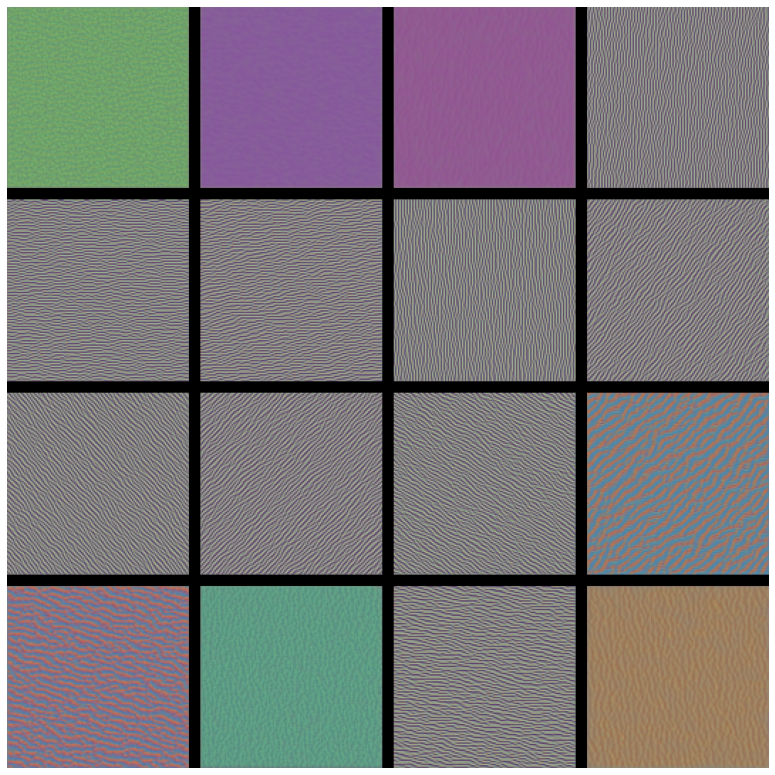

In [14]:
plot_grid(kept_filters, 'features.2')

# Block2 Conv2 

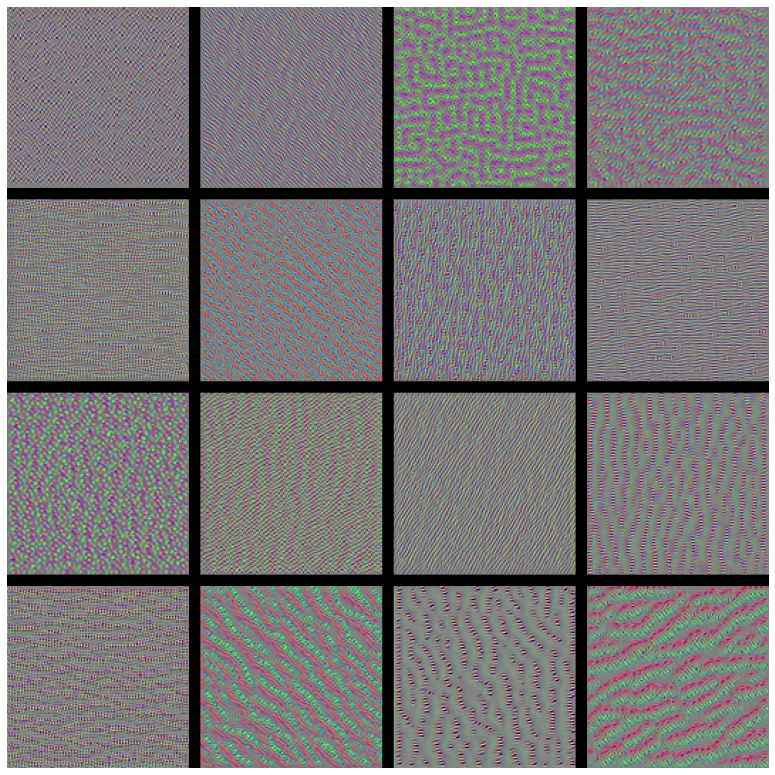

In [15]:
plot_grid(kept_filters, 'features.7')

# Block3 Conv3

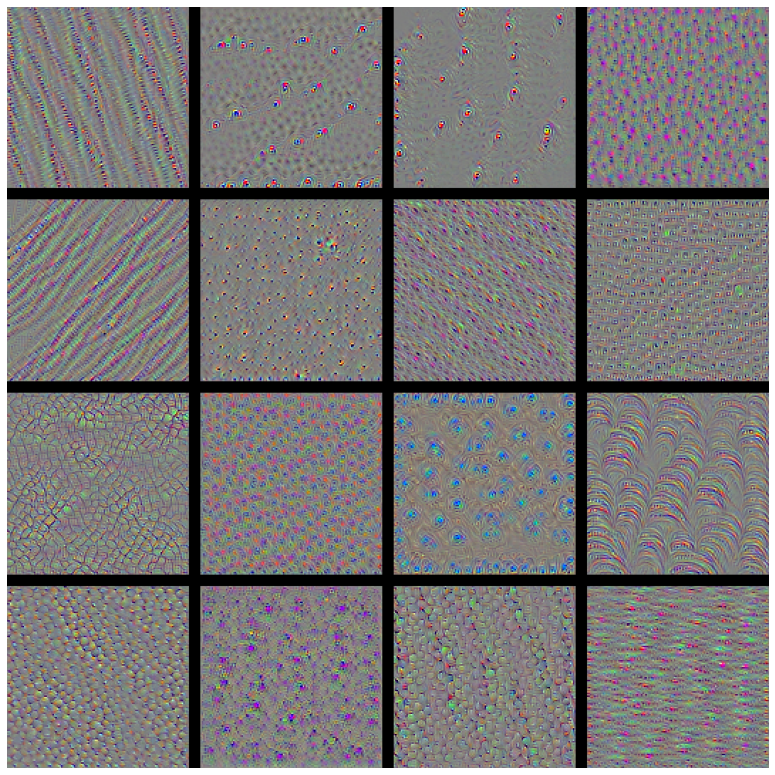

In [16]:
plot_grid(kept_filters, 'features.14')

# Block4 Conv1 

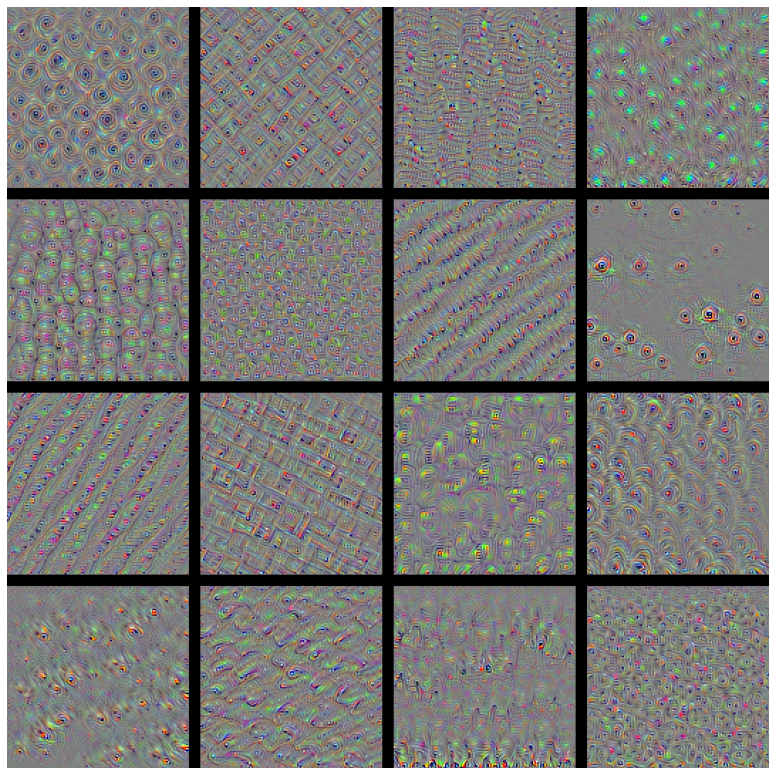

In [17]:
plot_grid(kept_filters, 'features.17')

# Block5 Conv1

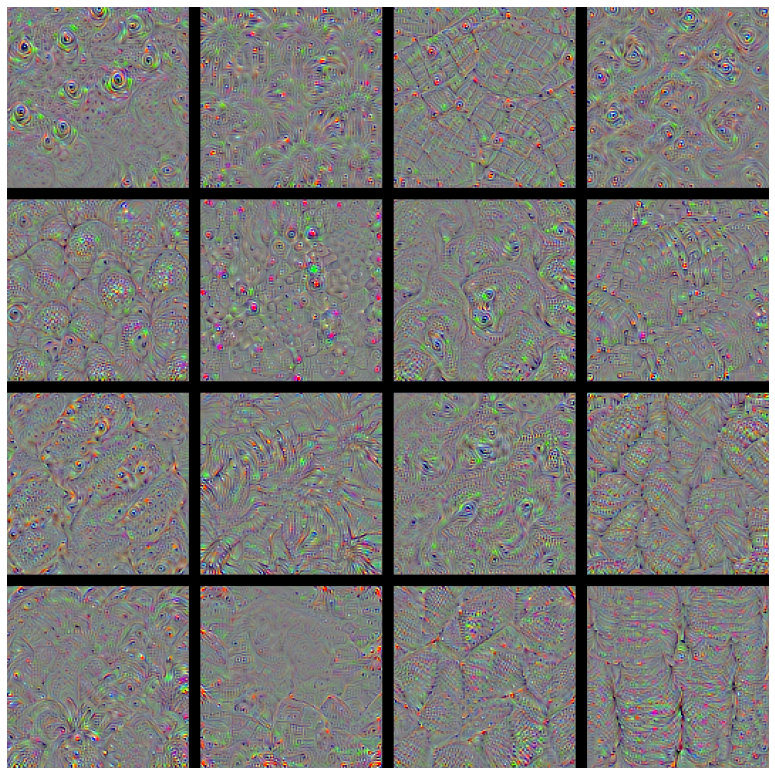

In [18]:
plot_grid(kept_filters, 'features.24')